In [1]:
import statsmodels
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
import time
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

In [2]:
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from cycler import cycler

hereon_color_array = np.array([
    [230, 0, 70],
    [0, 145, 160],
    [0, 170, 230],
    [250, 180, 35],
    [0, 70, 125],
    [175, 25, 60],
    [170, 200, 70],
    [250, 115, 80],
    [140, 90, 180],

])
hereon_color_array = hereon_color_array / 255
hereon_cmap = ListedColormap(hereon_color_array)
mpl.rc('image', cmap='gray')
mpl.rcParams['axes.prop_cycle'] = cycler(color=hereon_color_array)
sns.set_palette(hereon_color_array)

In [3]:
data = np.array([np.sin(np.linspace(0, np.pi*2*1007, 24168)) + np.random.uniform(0,1, size=24168) for _ in range(14)])
names = ["a", "b", "c", "as", "asd", "dfg", "jht", "hg", "hjn", "m", "hgw", "re", "ju", "ukj"]
dates = pd.date_range(start="2022-01-01", freq="h", periods=len(data.T))
with open("example_data_file.csv", "w") as f:
    f.write("Load [MWh],Time [s],City\n")
    for event, name in zip(data, names):
        for element, datum in zip(event, dates):
            f.write(f"{element:.5f},{datum.__str__()},{name}\n")

In [4]:
train_data_file = "example_data_file.csv"
valid_data_file = "example_data_file.csv"
prediction_time_window=168
past_time_window=168

In [5]:
df = pd.read_csv(train_data_file)
df

,Load [MWh],Time [s],City
0,0.84118,2022-01-01 00:00:00,a
1,0.67260,2022-01-01 01:00:00,a
2,0.69500,2022-01-01 02:00:00,a
3,1.66077,2022-01-01 03:00:00,a
4,1.27929,2022-01-01 04:00:00,a
...,...,...,...
338347,-0.73595,2024-10-03 19:00:00,ukj
338348,-0.36690,2024-10-03 20:00:00,ukj
338349,-0.40253,2024-10-03 21:00:00,ukj
338350,-0.15087,2024-10-03 22:00:00,ukj


In [6]:
city_data = []
city_names = pd.unique(df["City"])
for city in tqdm(city_names):
    city_data.append(df[df["City"] == city]["Load [MWh]"].to_numpy())

unique_time = np.expand_dims(pd.to_datetime(df[df["City"] == city]["Time [s]"]).view(np.int64).to_numpy() / 10**9 / 3600, 1)
city_data = np.moveaxis(np.array(city_data), 0, -1)
train_dataset = city_data

var_data = np.concatenate([unique_time, train_dataset], axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 62.22it/s]


In [7]:
# fit the model:
model = VAR(var_data)
model_fit = model.fit(maxlags=24*7)

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader


class CustomLoadDataset(Dataset):
    def __init__(self, data_file, historic_window, forecast_horizon, city_names, device=None, normalize=True):
        # Input sequence length and output (forecast) sequence length
        self.historic_window = historic_window
        self.forecast_horizon = forecast_horizon
        
        df = pd.read_csv(data_file)
        # Load Data from csv to Pandas Dataframe
        city_data = []
        for city in tqdm(city_names):
            city_data.append(df[df["City"] == city]["Load [MWh]"].to_numpy())

        unique_time = np.expand_dims(pd.to_datetime(df[df["City"] == city]["Time [s]"]).view(np.int64).to_numpy() / 10**9 / 3600, 1)
        city_data = np.moveaxis(np.array(city_data), 0, -1)
        self.dataset = city_data
        self.dataset = np.concatenate([unique_time, self.dataset], axis=1)

    def __len__(self):
#         return int(self.dataset.shape[0] - self.historic_window - self.forecast_horizon)
        return 100

    def __getitem__(self, idx):
        # translate idx (day nr) to array index
        x = self.dataset[idx:idx+self.historic_window, ]
        y = self.dataset[idx+self.historic_window: idx+self.historic_window + self.forecast_horizon, ]

        return x, y

In [9]:
valid_dataset = CustomLoadDataset(data_file=valid_data_file, 
                                  historic_window=past_time_window, 
                                  forecast_horizon=prediction_time_window,
                                  city_names=city_names,
                                  device=None, 
                                  normalize=False)

valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=True,
           num_workers=0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 59.57it/s]


In [10]:
errors = []
counter = 0

for x,y in tqdm(valid_dataloader):
    x = x.squeeze(0).cpu().numpy()
    y = y.squeeze(0).cpu().numpy()[:, 1:]
    preds = model_fit.forecast(x, steps=168)[:, 1:]
    
    # preds = valid_dataset.revert_normalization(preds)
    # y = valid_dataset.revert_normalization(y)
    
    all_predictions = preds
    all_val = y
    errors.append(mean_absolute_error(y_true=y, y_pred=preds))
    counter += 1
    if counter > 100:
        break

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.90it/s]


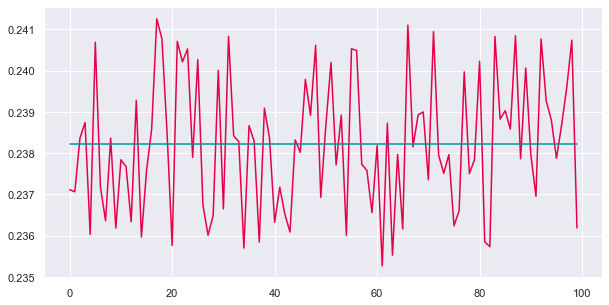

In [11]:
errors = np.array(errors)
mean_error = np.mean(errors)
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(errors)
ax.plot(np.arange(len(errors)), [mean_error for _ in range(len(errors))])

In [12]:
mean_error

0.23821181202885375

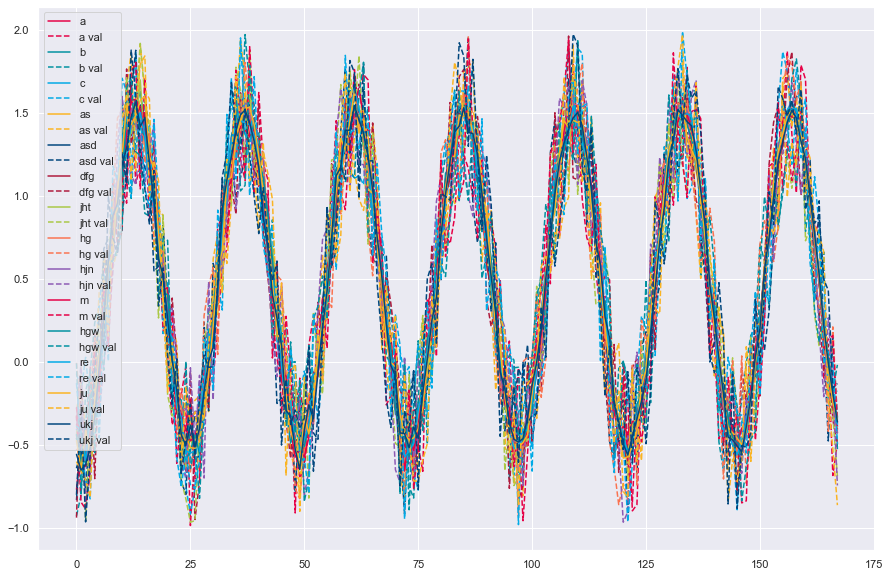

In [13]:
fig, ax1 = plt.subplots(figsize=(15,10), nrows=1)
for i, (this_pred, this_val) in enumerate(zip(np.array(all_predictions).T, np.array(all_val).T)):
    ax1.plot(np.arange(len(this_pred)), this_pred, label=city_names[i], color=hereon_color_array[i%9])
    ax1.plot(np.arange(len(this_pred)), this_val, label=city_names[i] + " val", color=hereon_color_array[i%9], ls="--")
ax1.legend()

## Parallel:

In [14]:
from joblib import Parallel, delayed

def do(x, y, counter):
    x = x.squeeze(0).cpu().numpy()
    y = y.squeeze(0).cpu().numpy()[:, 1:]
    preds = model_fit.forecast(x, steps=168)[:, 1:]

    return counter, preds

tqdm._instances.clear()
with Parallel(n_jobs=4) as parallel:
    results = parallel(delayed(do)(x, y, counter) for counter, (x, y) in enumerate(tqdm(valid_dataloader, position=0)))
sorted_predictions = np.array(list(pd.DataFrame(results, columns=["counter", "arrays"]).sort_values(by="counter")["arrays"].apply(lambda x: np.array(x))))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 33.34it/s]


In [15]:
def calc_error(x, y, counter):
    x = x.squeeze(0).cpu().numpy()
    y = y.squeeze(0).cpu().numpy()[:, 1:]
    preds = model_fit.forecast(x, steps=168)[:, 1:]
    error = mean_absolute_error(y_true=y, y_pred=preds)
    return counter, error

tqdm._instances.clear()
with Parallel(n_jobs=4) as parallel:
    results = parallel(delayed(do)(x, y, counter) for counter, (x, y) in enumerate(tqdm(valid_dataloader, position=0)))
sorted_predictions = np.array(list(pd.DataFrame(results, columns=["counter", "arrays"]).sort_values(by="counter")["arrays"].apply(lambda x: np.array(x))))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 72.07it/s]


In [16]:
sorted_predictions.mean()

0.5019173766824664

In [17]:
results[0][0]

0